In [2]:
# General
import sys
import os
import os.path as op
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py
import warnings

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from keras.utils import to_categorical
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects')
sys.path.append('/home1/dscho/code/projects/manning_replication')
from helper_funcs import *
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, place_analysis, goldmine_behavior
from time_cells.trial_phase_analysis import game_state_unit_fr_diff

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])

proj_dir = '/home1/dscho/projects/time_cells'

In [3]:
# Get mean firing rate in each 500ms time bin for all neurons.
proj_dir = '/home1/dscho/projects/time_cells'

# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

7 subjects, 9 sessions


In [17]:
# Load event_spikes for each session.
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
game_state_divs = [20, 80, 100] # time bin boundaries between game_states
spike_dat = []
for subj_sess in sessions:
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
    neurons = event_spikes.column_map['neurons']
    spike_dat.extend((event_spikes.event_spikes.query("(gameState=={})".format(game_states))
                                               .groupby(['gameState', 'time_bin'], observed=True)
                                               .agg({col: np.mean for col in neurons})).T
                     .to_numpy().tolist())
spike_dat = np.array(spike_dat) # neuron x time_bin

# Scale values to give firing rate in Hz.
spike_dat *= 2

print('spike_dat:', spike_dat.shape)

# Min-max scale each neuron's firing across the trial.
dat = minmax_scale(spike_dat, axis=1)

# Sort neurons by their peak firing time.
xsort = np.argsort(np.argmax(spike_dat, axis=1))
dat = dat[xsort, :]

# Split the data into separate game_states.
# _dat = np.split(dat, game_state_divs, axis=1) # game_state x neuron x time_bin
_dat = np.split(dat, 8, axis=1) # game_state x neuron x time_bin

spike_dat: (407, 160)


In [36]:
# Plot mean firing rates across the trial for every neuron.
save_fig = False
row_len = 50
col_len = 92
colspan = 10

# Parameters.
ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
# font = {'tick': 4.5,
#         'label': 5.5,
#         'fig': 6}
# params = {'linewidth': 0.5,
#           'labelpad': 2,
#           'tickpad': 1,
#           'ticklength': 1,
#           'figpad': 4}
font = {'tick': 8,
        'annot': 12,
        'label': 18,
        'fig': 22}
params = {'linewidth': 0.8,
          'labelpad': 8,
          'tickpad': 4,
          'ticklength': 3,
          'figpad': 6}

# Plot.
plt.close()
fig = plt.figure(figsize=(2 * colws['1'], 2 * colws['1'] * (row_len/col_len)), dpi=1200)
grid_shp = (row_len, col_len)

ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=row_len, colspan=colspan),
      plt.subplot2grid(grid_shp, (0, 11), rowspan=row_len, colspan=colspan),
      plt.subplot2grid(grid_shp, (0, 22), rowspan=row_len, colspan=colspan),
      plt.subplot2grid(grid_shp, (0, 33), rowspan=row_len, colspan=colspan),
      plt.subplot2grid(grid_shp, (0, 44), rowspan=row_len, colspan=colspan),
      plt.subplot2grid(grid_shp, (0, 55), rowspan=row_len, colspan=colspan),
      plt.subplot2grid(grid_shp, (0, 66), rowspan=row_len, colspan=colspan),
      plt.subplot2grid(grid_shp, (0, 77), rowspan=row_len, colspan=colspan),
      
      plt.subplot2grid(grid_shp, (0, 88), rowspan=row_len, colspan=4)]
ax = np.ravel(ax)

# Plot the data.
for iax in range(len(ax)-1):
    add_cbar = True if (iax == len(ax) - 2) else False
    ax[iax] = sns.heatmap(_dat[iax], vmin=0, vmax=1, cmap='rocket', square=False, 
                          cbar=add_cbar, ax=ax[iax], cbar_ax=ax[iax+1])
    ax[iax].tick_params(labelsize=font['tick'], pad=params['tickpad'],
                        length=params['ticklength'], width=params['linewidth'])
    ax[iax].set_xticks(np.arange(0, _dat[iax].shape[1]+1, 10))
    ax[iax].set_xticklabels((iax * 10) + np.arange(0, (_dat[iax].shape[1]+1)/2, 5, dtype=np.int),
                            fontsize=font['tick'], rotation=0)
    ax[iax].set_yticks([])
    if iax == 0:
        ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=params['labelpad'])
        ax[iax].set_ylabel('Neuron 1..{}'.format(_dat[iax].shape[0]), 
                           fontsize=font['label'], labelpad=params['labelpad'])
#     ax[iax].set_title(ax_labels[game_state], pad=params['figpad'], fontsize=font['fig'])
    
    if add_cbar:
        cbar = ax[iax].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['annot'], length=params['ticklength'],
                            width=params['linewidth'], pad=params['tickpad'])
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=params['labelpad'])
        
fig.show()
if save_fig:
    filename = op.join(proj_dir, 'figs', 'all_neuron_FRs_over_time-trialwise_scaled-{}units.pdf'.format(_dat[0].shape[0]))
    fig.savefig(filename, format='pdf', dpi=600, bbox_inches='tight')

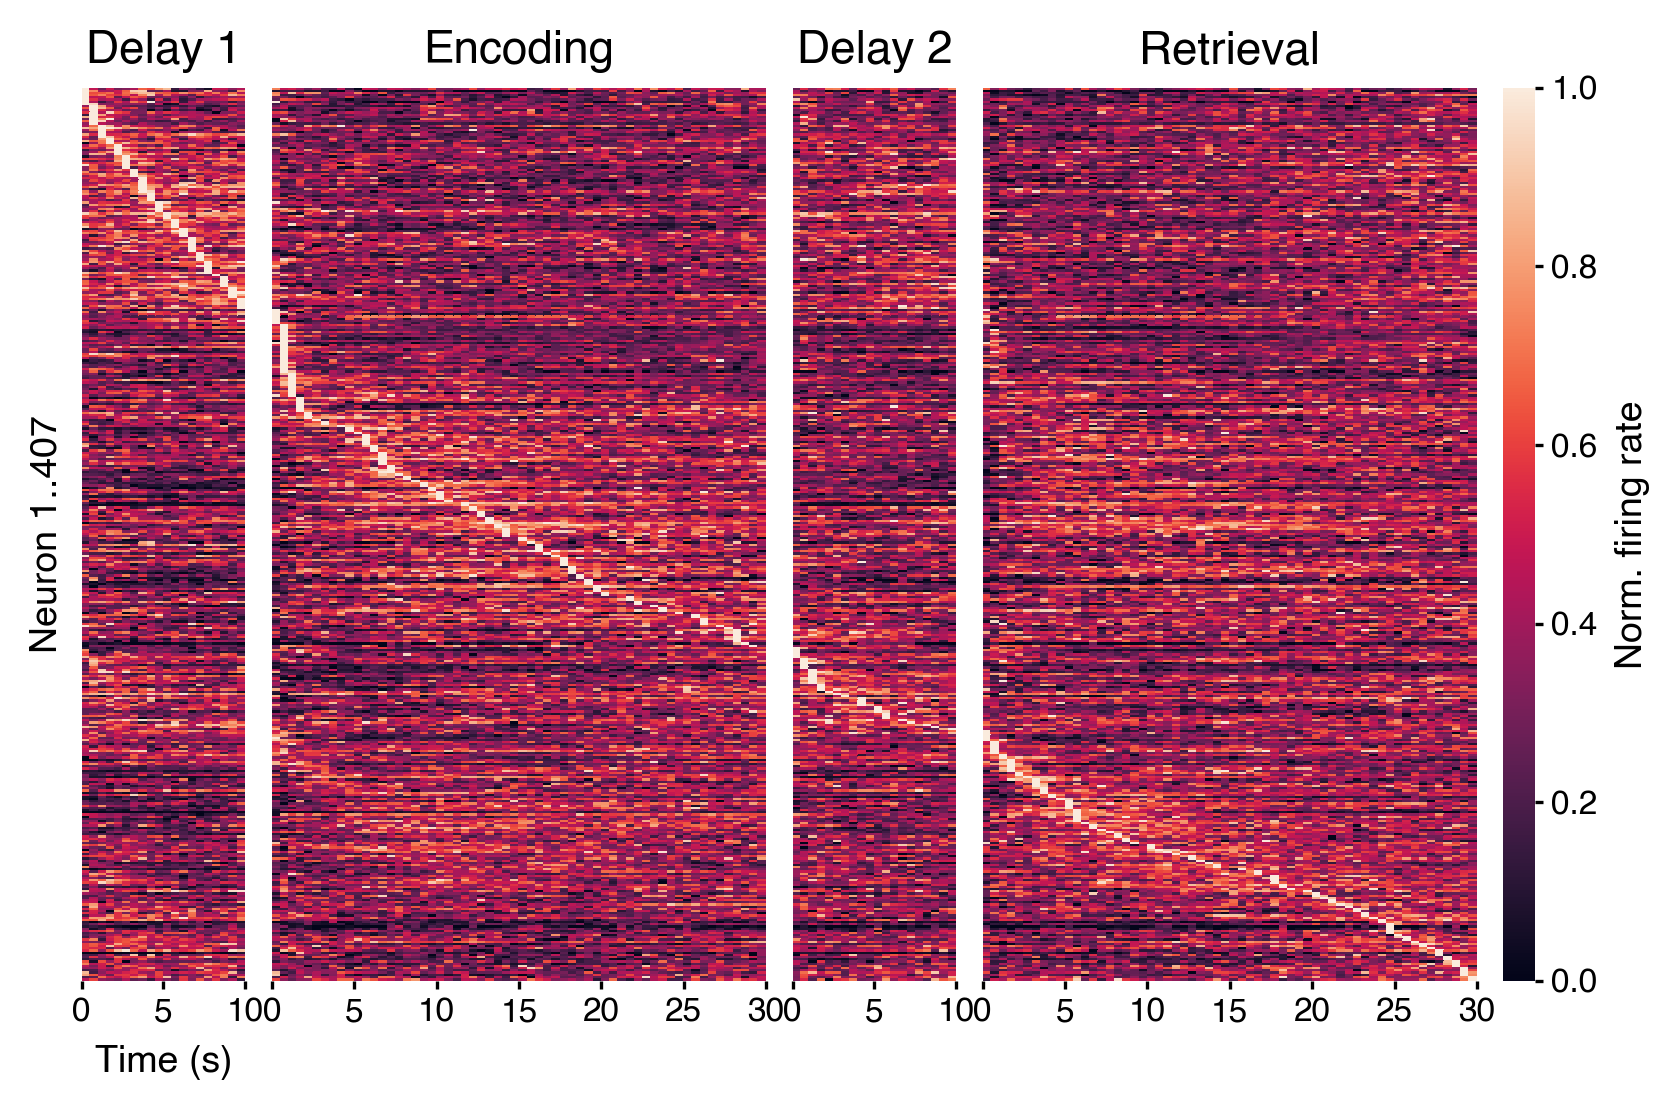

In [16]:
# Plot mean firing rates across the trial for every neuron.
save_fig = False
row_len = int(335/3)
col_len = 176

# Parameters.
ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
# font = {'tick': 4.5,
#         'label': 5.5,
#         'fig': 6}
# params = {'linewidth': 0.5,
#           'labelpad': 2,
#           'tickpad': 1,
#           'ticklength': 1,
#           'figpad': 4}
font = {'tick': 8,
        'label': 9,
        'fig': 11}
params = {'linewidth': 0.8,
          'labelpad': 4,
          'tickpad': 2,
          'ticklength': 2,
          'figpad': 6}

# Plot.
plt.close()
fig = plt.figure(figsize=(2 * colws[2], 2 * colws[2] * (row_len/col_len)), dpi=300)
grid_shp = (row_len, col_len)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=row_len, colspan=20),
      plt.subplot2grid(grid_shp, (0, 23), rowspan=row_len, colspan=60),
      plt.subplot2grid(grid_shp, (0, 86), rowspan=row_len, colspan=20),
      plt.subplot2grid(grid_shp, (0, 109), rowspan=row_len, colspan=60),
      plt.subplot2grid(grid_shp, (0, 172), rowspan=row_len, colspan=4)]
ax = np.ravel(ax)

# Plot the data.
for iax, game_state in enumerate(game_states):
    add_cbar = True if (iax == len(game_states) - 1) else False
    ax[iax] = sns.heatmap(dat[iax], vmin=0, vmax=1, cmap='rocket', square=False, 
                          cbar=add_cbar, ax=ax[iax], cbar_ax=ax[iax+1])
    ax[iax].tick_params(labelsize=font['tick'], pad=params['tickpad'],
                        length=params['ticklength'], width=params['linewidth'])
    ax[iax].set_xticks(np.arange(0, dat[iax].shape[1]+1, 10))
    ax[iax].set_xticklabels(np.arange(0, (dat[iax].shape[1]+1)/2, 5, dtype=np.int),
                            fontsize=font['tick'], rotation=0)
    ax[iax].set_yticks([])
    if iax == 0:
        ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=params['labelpad'])
        ax[iax].set_ylabel('Neuron 1..{}'.format(dat[iax].shape[0]), 
                           fontsize=font['label'], labelpad=params['labelpad'])
    ax[iax].set_title(ax_labels[game_state], pad=params['figpad'], fontsize=font['fig'])
    
    if add_cbar:
        cbar = ax[iax].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], length=params['ticklength'],
                            width=params['linewidth'], pad=params['tickpad'])
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=params['labelpad'])
        
fig.show()
if save_fig:
    filename = op.join(proj_dir, 'figs', 'all_neuron_FRs_over_time-trialwise_scaled-{}units.pdf'.format(dat[0].shape[0]))
    fig.savefig(filename, format='pdf', dpi=600, bbox_inches='tight')

In [207]:
# Load event_spikes for each session.
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
game_state_divs = [20, 80, 100] # time bin boundaries between game_states
spike_dat = []
for trial_is_even in [0, 1]:
    spike_dat.append([])
    for subj_sess in sessions:
        event_spikes = time_bin_analysis.load_event_spikes(subj_sess)
        event_spikes.insert(event_spikes.columns.tolist().index('trial') + 1, 
                            'even_trial',
                            event_spikes['trial'].apply(lambda x: int(1 * (x % 2 == 0))))
        es_cols = time_bin_analysis.event_spike_cols(event_spikes)
        spike_dat[-1].extend((event_spikes.query("(gameState=={}) & (even_trial=={})".format(game_states, trial_is_even))
                                          .groupby(['gameState', 'time_bin'])
                                          .agg({col: np.mean for col in es_cols['neurons']})).T
                             .to_numpy().tolist())
spike_dat = np.array(spike_dat) # is_even x neuron x time_bin

# Scale values to give firing rate in Hz.
spike_dat *= 2

print('spike_dat:', spike_dat.shape)

# Min-max scale each neuron's firing across the trial,
# independently for odd and even trials.
dat = spike_dat.copy()
for is_even in [0, 1]:
    dat[is_even, :, :] = minmax_scale(spike_dat[is_even, :, :], axis=1)
    
# Sort neurons by their peak firing time on odd trials.
is_even = 0
xsort = np.argsort(np.argmax(spike_dat[is_even, :, :], axis=1))
for is_even in [0, 1]:
    dat[is_even, :, :] = dat[is_even, xsort, :]

# Split the data into separate game_states.
dat = np.split(dat, game_state_divs, axis=2) # game_state x is_even x neuron x time_bin

spike_dat: (2, 335, 160)


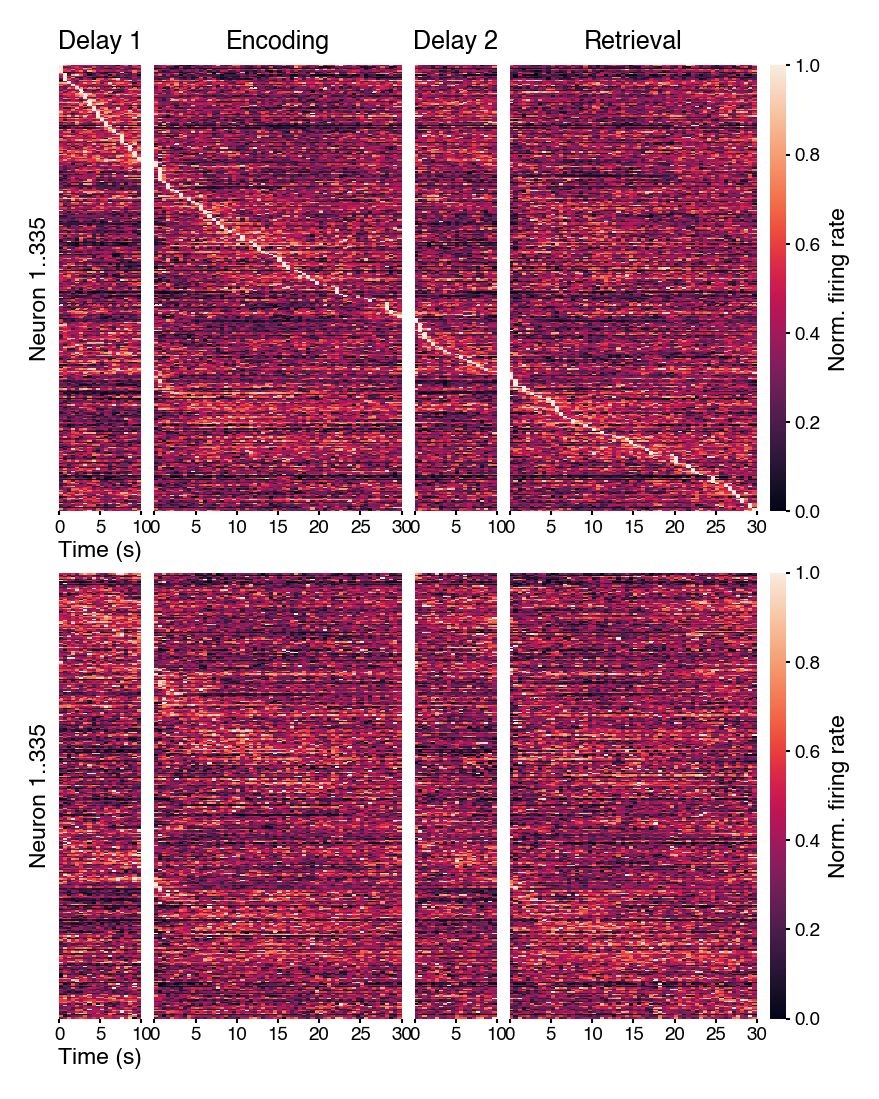

In [213]:
# Plot mean firing rates across the trial for every neuron.
save_fig = False
row_len = 15 + (2 * int(335/3))
col_len = 176

# Parameters.
ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
font = {'tick': 4.5,
        'label': 5.5,
        'fig': 6}
params = {'linewidth': 0.5,
          'labelpad': 2,
          'tickpad': 1,
          'ticklength': 1}

# Plot.
plt.close()
fig = plt.figure(figsize=(colws[2], colws[2] * (row_len/col_len)), dpi=300)
grid_shp = (row_len, col_len)
half_row = int((row_len-15) / 2)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=half_row, colspan=20),
      plt.subplot2grid(grid_shp, (0, 23), rowspan=half_row, colspan=60),
      plt.subplot2grid(grid_shp, (0, 86), rowspan=half_row, colspan=20),
      plt.subplot2grid(grid_shp, (0, 109), rowspan=half_row, colspan=60),
      plt.subplot2grid(grid_shp, (0, 172), rowspan=half_row, colspan=4),
      
      plt.subplot2grid(grid_shp, (15 + half_row, 0), rowspan=half_row, colspan=20),
      plt.subplot2grid(grid_shp, (15 + half_row, 23), rowspan=half_row, colspan=60),
      plt.subplot2grid(grid_shp, (15 + half_row, 86), rowspan=half_row, colspan=20),
      plt.subplot2grid(grid_shp, (15 + half_row, 109), rowspan=half_row, colspan=60),
      plt.subplot2grid(grid_shp, (15 + half_row, 172), rowspan=half_row, colspan=4)]
ax = np.ravel(ax)

# Plot the data.
for is_even in [0, 1]:
    for _i, game_state in enumerate(game_states):
        iax = (is_even * (1 + len(game_states))) + _i
        add_cbar = True if (_i == len(game_states) - 1) else False
        ax[iax] = sns.heatmap(dat[_i][is_even, :, :], vmin=0, vmax=1, cmap='rocket', square=False, 
                              cbar=add_cbar, ax=ax[iax], cbar_ax=ax[iax+1])
        ax[iax].tick_params(labelsize=font['tick'], pad=params['tickpad'],
                            length=params['ticklength'], width=params['linewidth'])
        if is_even == 0:
#             ax[iax].set_xticks([])
            ax[iax].set_xticks(np.arange(0, dat[_i][is_even, :, :].shape[1]+1, 10))
            ax[iax].set_xticklabels(np.arange(0, (dat[_i][is_even, :, :].shape[1]+1)/2, 5, dtype=np.int),
                                    fontsize=font['tick'], rotation=0)
        else:
            ax[iax].set_xticks(np.arange(0, dat[_i][is_even, :, :].shape[1]+1, 10))
            ax[iax].set_xticklabels(np.arange(0, (dat[_i][is_even, :, :].shape[1]+1)/2, 5, dtype=np.int),
                                    fontsize=font['tick'], rotation=0)
        ax[iax].set_yticks([])
        if _i == 0:
#             if is_even == 1:
            ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=params['labelpad']-1)
            ax[iax].set_ylabel('Neuron 1..{}'.format(dat[_i][is_even, :, :].shape[0]), 
                               fontsize=font['label'], labelpad=params['labelpad'])
        if is_even == 0:
            ax[iax].set_title(ax_labels[game_state], pad=4, fontsize=font['fig'])

        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], length=params['ticklength'],
                                width=params['linewidth'], pad=params['tickpad'])
            cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=params['labelpad'])
        
fig.show()
if save_fig:
    filename = op.join(proj_dir, 'figs', 'all_neuron_FRs_over_time-even_odd_trial_split-trialwise_scaled-{}units.pdf'.format(dat[0].shape[1]))
    fig.savefig(filename, format='pdf', dpi=600, bbox_inches='tight')

In [3]:
# Load all time, place OLS result files.
proj_dir = '/home1/dscho/projects/time_cells'
seq_pairs_files = glob(op.join(proj_dir, 'analysis', 'unit_to_behav', '*-ols-game_state-model_pairs.pkl'))
print('Found OLS outputs for {} neurons'.format(len(seq_pairs_files)))

warnings.filterwarnings('ignore')
bad_files = []
seq_pairs = pd.DataFrame([])
for filename in seq_pairs_files:
    try:
        seq_pairs = pd.concat((seq_pairs, dio.open_pickle(filename)))
    except:
        bad_files.append(filename)
seq_pairs = seq_pairs.sort_values(['subj_sess', 'neuron']).reset_index(drop=True)
warnings.resetwarnings()

testvars = ['omnibus', 
            'Delay1_Encoding', 'Delay1_Delay2', 'Delay1_Retrieval',
            'Encoding_Delay2', 'Encoding_Retrieval', 'Delay2_Retrieval']
testvar_cat = pd.CategoricalDtype(testvars, ordered=True)
seq_pairs['testvar'] = seq_pairs['testvar'].astype(testvar_cat)

# Add new columns.
roi_map = spike_preproc.roi_mapping(n=3)
val_map = od([('hem', []),
              ('roi', []),
              ('roi_gen', [])])
for idx, row in seq_pairs.iterrows():
    hemroi = spike_preproc.roi_lookup(row['subj_sess'], row['neuron'].split('-')[0])
    hem = hemroi[0]
    roi = hemroi[1:]
    roi_gen = roi_map.get(roi, np.nan)
    val_map['hem'].append(hem)
    val_map['roi'].append(roi)
    val_map['roi_gen'].append(roi_gen)

seq_pairs.insert(0, 'subj_sess_unit', seq_pairs.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['neuron']), axis=1))
seq_pairs.insert(1, 'subj', seq_pairs['subj_sess'].apply(lambda x: x.split('_')[0]))
seq_pairs.insert(4, 'hem', val_map['hem'])
seq_pairs.insert(5, 'roi', val_map['roi'])
seq_pairs.insert(6, 'roi_gen', val_map['roi_gen'])
for col_name in val_map:
    if col_name not in seq_pairs:
        seq_pairs[col_name] = val_map[col_name]
        
# Get a list of neurons that meet omnibus significance.
omni_sig_cells = seq_pairs.query("(testvar=='omnibus') & (sig==True)")['subj_sess_unit'].tolist()

print('{} bad files'.format(len(bad_files)))
print('seq_pairs:', seq_pairs.shape)
print('{}/{} ({:.1%}) units meet omnibus significance'.format(len(omni_sig_cells), 
                                                              len(np.unique(seq_pairs['subj_sess_unit'])), 
                                                              len(omni_sig_cells)/len(np.unique(seq_pairs['subj_sess_unit']))))

Found OLS outputs for 407 neurons
0 bad files
seq_pairs: (2849, 11)
244/407 (60.0%) units meet omnibus significance


In [108]:
# What percent of units pass the omnibus test, in each region?
(seq_pairs.query("(testvar=='omnibus')")
          .groupby('roi_gen', observed=True)
          .agg({'sig': lambda x: '{}/{} ({:.1%})'.format(np.sum(x), len(x), np.mean(x))}))

,sig
roi_gen,
Cortex,89/136 (65.4%)
Hippocampus,52/88 (59.1%)
MTL,103/183 (56.3%)


In [107]:
# What percent of units pass significance for each posthoc test, in each region?
(seq_pairs.query("(subj_sess_unit=={}) & (testvar!='omnibus')".format(omni_sig_cells))
          .groupby(['testvar', 'roi_gen'], observed=True)
          .agg({'sig': lambda x: '{}/{} ({:.1%})'.format(np.sum(x), len(x), np.mean(x))}))

sig
testvar            roi_gen                    
Delay1_Encoding    Cortex        61/89 (68.5%)
                   Hippocampus   36/52 (69.2%)
                   MTL          74/103 (71.8%)
Delay1_Delay2      Cortex        11/89 (12.4%)
                   Hippocampus   12/52 (23.1%)
                   MTL          16/103 (15.5%)
Delay1_Retrieval   Cortex        59/89 (66.3%)
                   Hippocampus   25/52 (48.1%)
                   MTL          65/103 (63.1%)
Encoding_Delay2    Cortex        58/89 (65.2%)
                   Hippocampus   23/52 (44.2%)
                   MTL          46/103 (44.7%)
Encoding_Retrieval Cortex        13/89 (14.6%)
                   Hippocampus   11/52 (21.2%)
                   MTL          20/103 (19.4%)
Delay2_Retrieval   Cortex        52/89 (58.4%)
                   Hippocampus   18/52 (34.6%)
                   MTL          45/103 (43.7%)

In [104]:
# How strong are the significant units?
(seq_pairs.query("(subj_sess_unit=={}) & (sig==True)".format(omni_sig_cells))
          .groupby(['testvar', 'roi_gen'])
          .agg({'neuron': len, 
                'z_lr': lambda x: '{:.1f} ± {:.1f}'.format(np.mean(x), np.std(x))}))

neuron         z_lr
testvar            roi_gen                         
omnibus            Cortex           89  13.9 ± 17.1
                   Hippocampus      52    8.4 ± 6.1
                   MTL             103  11.6 ± 12.0
Delay1_Encoding    Cortex           61  16.5 ± 14.4
                   Hippocampus      36   11.7 ± 6.9
                   MTL              74  14.6 ± 10.9
Delay1_Delay2      Cortex           11    7.7 ± 4.4
                   Hippocampus      12    8.4 ± 5.3
                   MTL              16    6.3 ± 2.7
Delay1_Retrieval   Cortex           59  15.1 ± 15.2
                   Hippocampus      25    8.9 ± 5.0
                   MTL              65  13.6 ± 11.6
Encoding_Delay2    Cortex           58  14.7 ± 14.8
                   Hippocampus      23    8.7 ± 4.5
                   MTL              46  14.0 ± 10.8
Encoding_Retrieval Cortex           13    9.7 ± 3.1
                   Hippocampus      11    7.7 ± 4.1
                   MTL              20    9.3 ± 5.6
Delay2_Retrieval   Cortex           52  14.9 ± 14.6
                   Hippocampus      18    7.6 ± 3.5
                   MTL              45   12.5 ± 9.9

In [81]:
# Load event_spikes for each session.
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
game_state_divs = [20, 80, 100] # time bin boundaries between game_states
spike_dat = []
for is_even in [0, 1]:
    spike_dat.append([])
    for subj_sess in sessions:
        event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
        event_spikes.event_spikes.insert(event_spikes.event_spikes.columns.tolist().index('trial') + 1, 
                                         'even_trial',
                                         event_spikes.event_spikes['trial'].apply(lambda x: int(1 * (x % 2 == 0))))
        keep_cells = [unit for unit in event_spikes.column_map['neurons'] if '{}-{}'.format(subj_sess, unit) in omni_sig_cells]
        
        arr = []
        for game_state in game_states:
            arr.append(event_spikes.event_spikes.query("(gameState=='{}') & (even_trial=={})".format(game_state, is_even))
                                                .groupby('time_bin')
                                                .agg({col: np.mean for col in keep_cells}).T.values)
        arr = np.concatenate(arr, axis=1) # neuron x time_bin across all 4 game states
        spike_dat[-1].extend(arr)
spike_dat = np.array(spike_dat) # is_even x neuron x time_bin

# Scale values to give firing rate in Hz.
spike_dat *= 2

print('spike_dat:', spike_dat.shape)

# Min-max scale each neuron's firing across the trial,
# independently for odd and even trials.
dat = spike_dat.copy()
for is_even in [0, 1]:
    dat[is_even, :, :] = minmax_scale(spike_dat[is_even, :, :], axis=1)
    
# # Sort neurons by their peak firing time on odd trials.
# is_even = 0
# xsort = np.argsort(np.argmax(spike_dat[is_even, :, :], axis=1))

# Sort neurons by their peak firing game state (averaging across time bins).
# Then within each game state, sort neurons by their peak firing time.
is_even = 0
pref_trial_phase = np.argmax(np.array([np.mean(_arr, axis=1) for _arr in np.split(spike_dat[is_even, :, :], game_state_divs, axis=1)]), axis=0)
pref_trial_phase = od({game_state: np.where(pref_trial_phase==_i)[0] for (_i, game_state) in enumerate(game_states)})
_game_state_divs = [0] + game_state_divs + [spike_dat.shape[2]]
xsort = []
for _i, game_state in enumerate(game_states):
    start, stop = _game_state_divs[_i], _game_state_divs[_i+1]
    xsort += list(pref_trial_phase[game_state][np.argsort(np.argmax(spike_dat[is_even, pref_trial_phase[game_state], start:stop], axis=1))])

for is_even in [0, 1]:
    dat[is_even, :, :] = dat[is_even, xsort, :]

# Split the data into separate game_states.
dat = np.split(dat, game_state_divs, axis=2) # game_state x is_even x neuron x time_bin

spike_dat: (2, 244, 160)


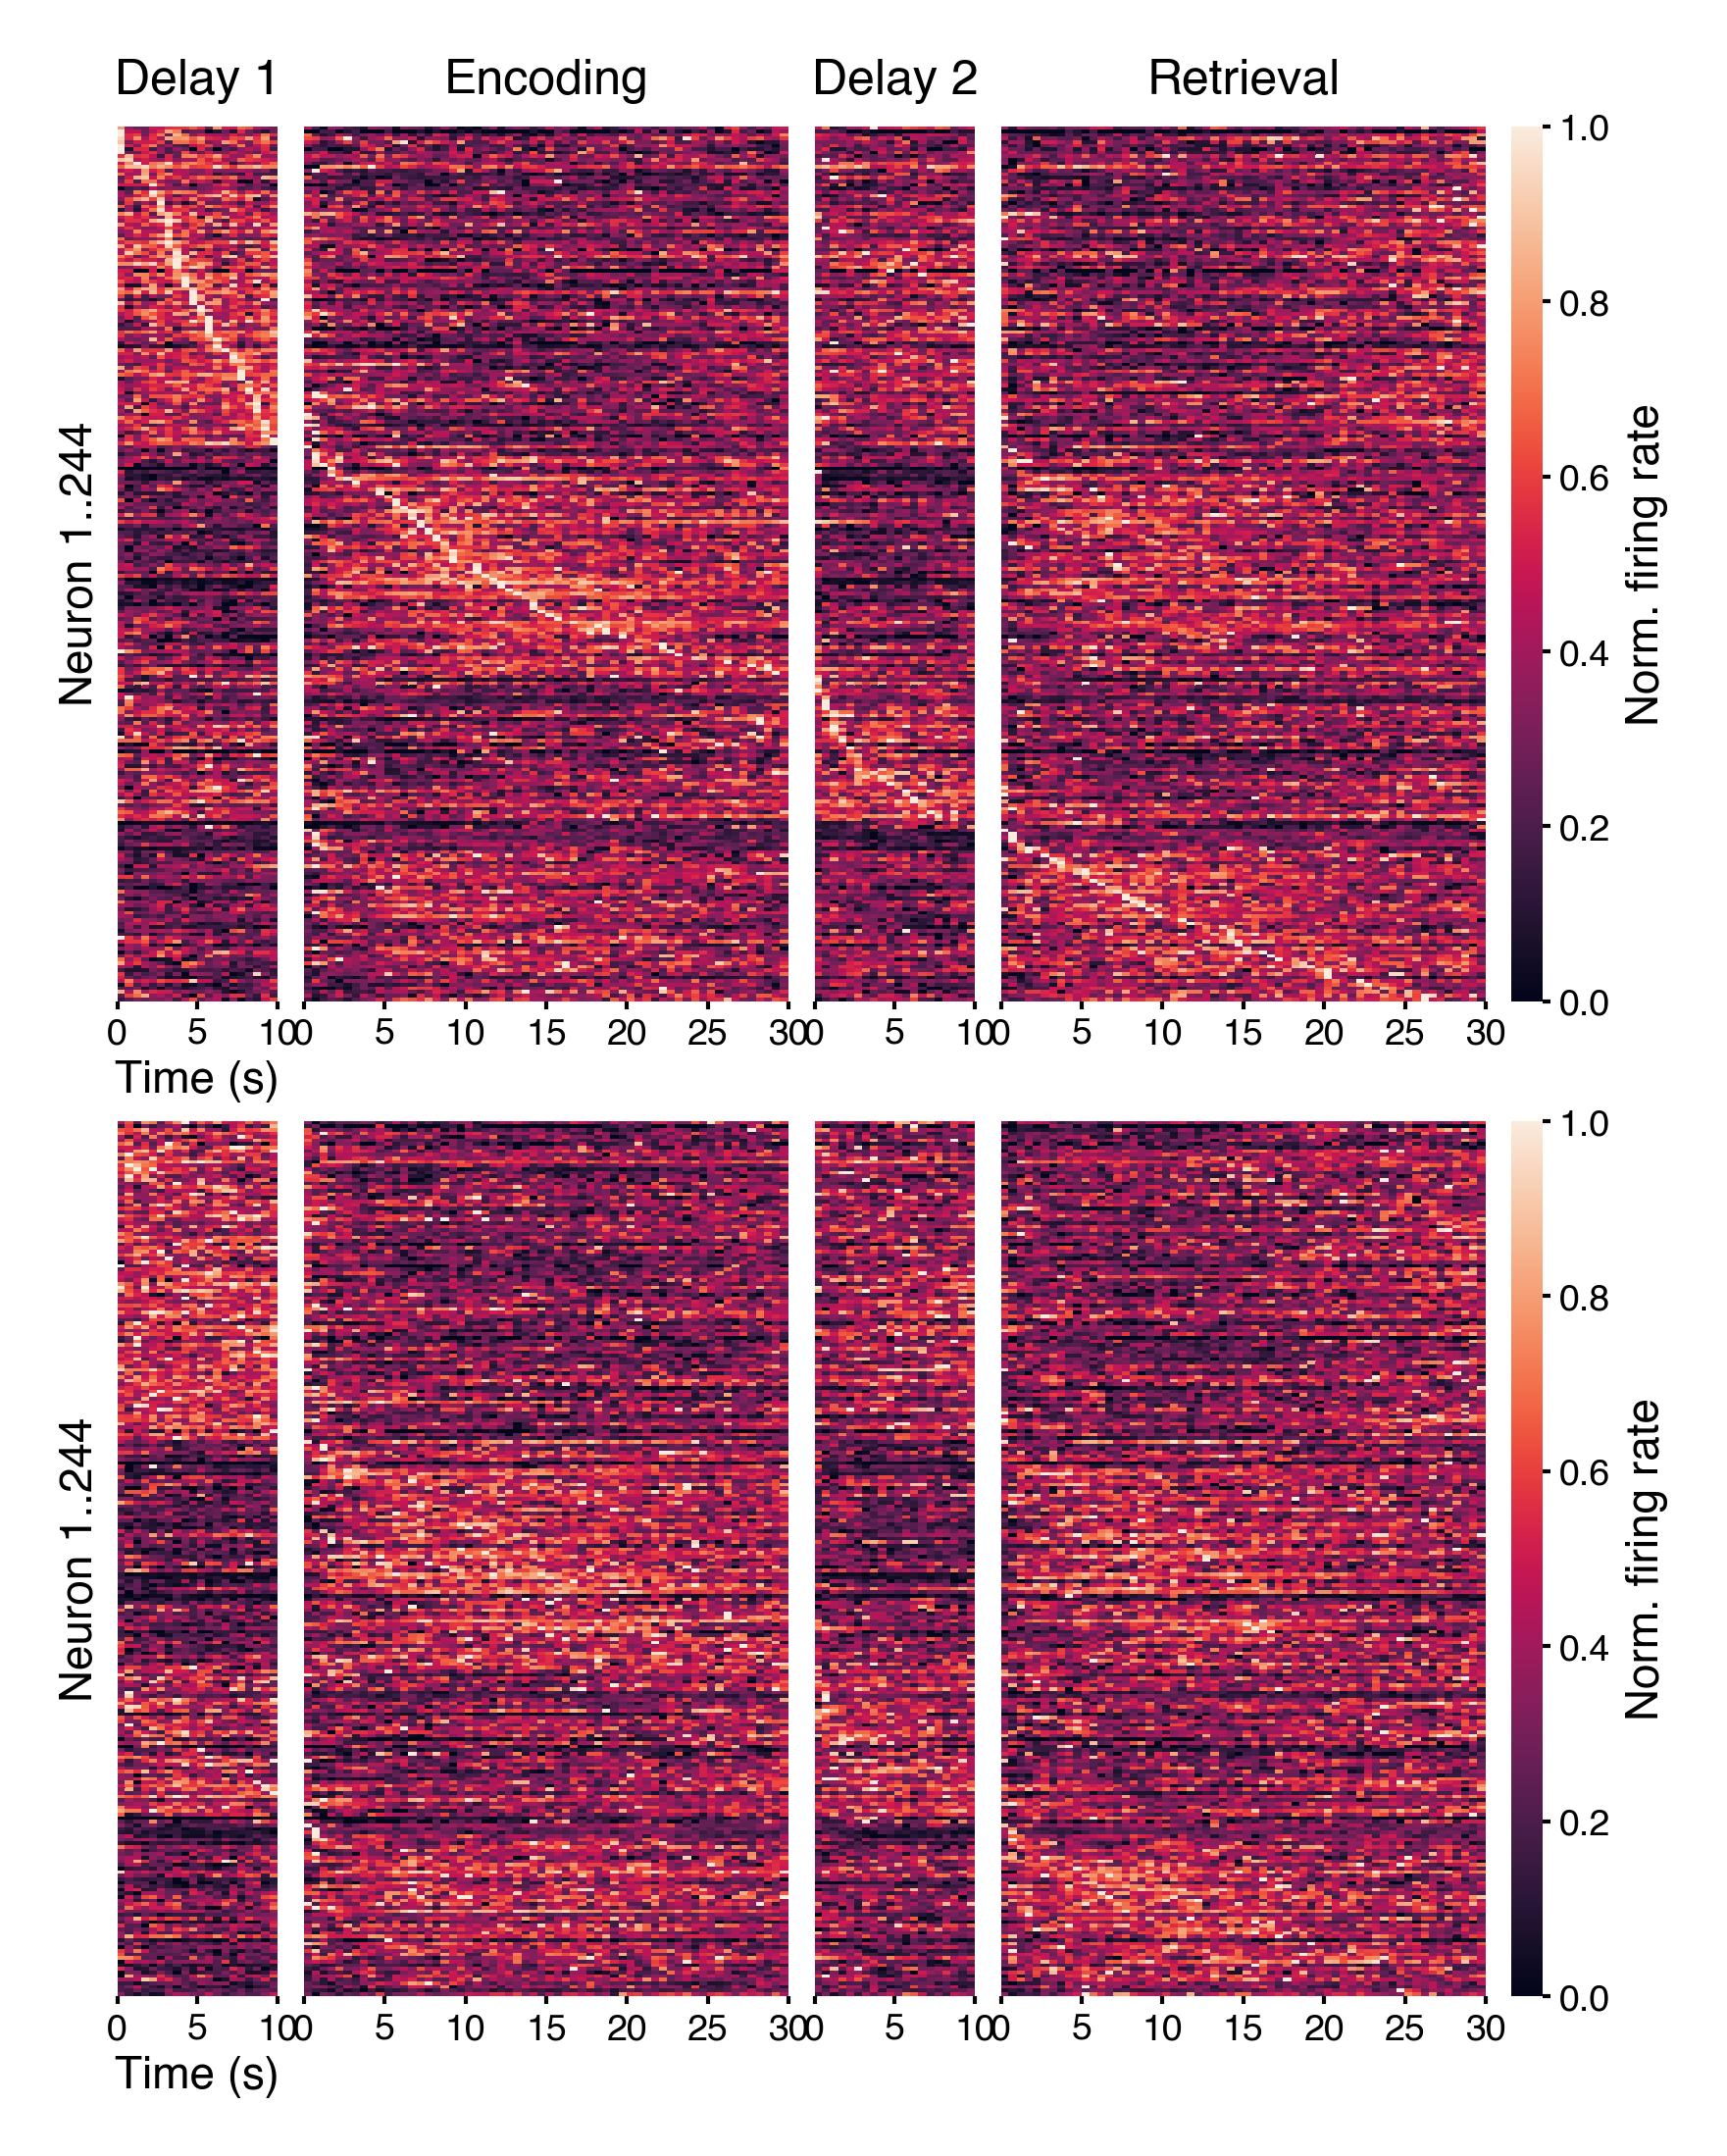

In [82]:
# Plot mean firing rates across the trial for every neuron.
save_fig = True
row_len = 15 + (2 * int(335/3))
col_len = 176

# Parameters.
ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
font = {'tick': 4.5,
        'label': 5.5,
        'fig': 6}
params = {'linewidth': 0.5,
          'labelpad': 2,
          'tickpad': 1,
          'ticklength': 1}

# Plot.
plt.close()
fig = plt.figure(figsize=(colws[2], colws[2] * (row_len/col_len)), dpi=600)
grid_shp = (row_len, col_len)
half_row = int((row_len-15) / 2)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=half_row, colspan=20),
      plt.subplot2grid(grid_shp, (0, 23), rowspan=half_row, colspan=60),
      plt.subplot2grid(grid_shp, (0, 86), rowspan=half_row, colspan=20),
      plt.subplot2grid(grid_shp, (0, 109), rowspan=half_row, colspan=60),
      plt.subplot2grid(grid_shp, (0, 172), rowspan=half_row, colspan=4),
      
      plt.subplot2grid(grid_shp, (15 + half_row, 0), rowspan=half_row, colspan=20),
      plt.subplot2grid(grid_shp, (15 + half_row, 23), rowspan=half_row, colspan=60),
      plt.subplot2grid(grid_shp, (15 + half_row, 86), rowspan=half_row, colspan=20),
      plt.subplot2grid(grid_shp, (15 + half_row, 109), rowspan=half_row, colspan=60),
      plt.subplot2grid(grid_shp, (15 + half_row, 172), rowspan=half_row, colspan=4)]
ax = np.ravel(ax)

# Plot the data.
for is_even in [0, 1]:
    for _i, game_state in enumerate(game_states):
        iax = (is_even * (1 + len(game_states))) + _i
        add_cbar = True if (_i == len(game_states) - 1) else False
        ax[iax] = sns.heatmap(dat[_i][is_even, :, :], vmin=0, vmax=1, cmap='rocket', square=False, 
                              cbar=add_cbar, ax=ax[iax], cbar_ax=ax[iax+1])
        ax[iax].tick_params(labelsize=font['tick'], pad=params['tickpad'],
                            length=params['ticklength'], width=params['linewidth'])
        if is_even == 0:
            ax[iax].set_xticks(np.arange(0, dat[_i][is_even, :, :].shape[1]+1, 10))
            ax[iax].set_xticklabels(np.arange(0, (dat[_i][is_even, :, :].shape[1]+1)/2, 5, dtype=np.int),
                                    fontsize=font['tick'], rotation=0)
        else:
            ax[iax].set_xticks(np.arange(0, dat[_i][is_even, :, :].shape[1]+1, 10))
            ax[iax].set_xticklabels(np.arange(0, (dat[_i][is_even, :, :].shape[1]+1)/2, 5, dtype=np.int),
                                    fontsize=font['tick'], rotation=0)
        ax[iax].set_yticks([])
        if _i == 0:
            ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=params['labelpad']-1)
            ax[iax].set_ylabel('Neuron 1..{}'.format(dat[_i][is_even, :, :].shape[0]), 
                               fontsize=font['label'], labelpad=params['labelpad'])
        if is_even == 0:
            ax[iax].set_title(ax_labels[game_state], pad=4, fontsize=font['fig'])

        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], length=params['ticklength'],
                                width=params['linewidth'], pad=params['tickpad'])
            cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=params['labelpad'])
        
fig.show()
if save_fig:
    filename = op.join(proj_dir, 'figs', 'sequence_cell_FRs_over_time-even_odd_trial_split-trialwise_scaled-{}units.png'.format(dat[0].shape[1]))
    fig.savefig(filename, format='png', dpi=600, bbox_inches='tight')
    
    filename = op.join(proj_dir, 'figs', 'sequence_cell_FRs_over_time-even_odd_trial_split-trialwise_scaled-{}units.pdf'.format(dat[0].shape[1]))
    fig.savefig(filename, format='pdf', bbox_inches='tight')

In [132]:
print(seq_pairs.query("(testvar=='Delay1_Delay2') & (sig==True)").shape, seq_pairs.query("(testvar=='Encoding_Retrieval') & (sig==True)").shape)

(35, 11) (40, 11)


In [133]:
seq_pairs.query("(subj_sess_unit=='U532_ses0-21-1')")

,subj_sess_unit,subj_sess,neuron,testvar,llf_full,lr,z_lr,df,pval,sig,null_hist
2009,U532_ses0-21-1,U532_ses0,21-1,omnibus,-99.414126,59.405033,17.247501,3,0.000999,True,"([107, 141, 120, 126, 86, 91, 69, 58, 46, 42, ..."
2010,U532_ses0-21-1,U532_ses0,21-1,Delay1_Encoding,-43.333564,52.503419,17.378015,1,0.000999,True,"([455, 156, 103, 58, 44, 37, 27, 21, 17, 15, 1..."
2011,U532_ses0-21-1,U532_ses0,21-1,Delay1_Delay2,-42.486657,39.029406,14.069100,1,0.000999,True,"([366, 141, 99, 70, 64, 40, 37, 32, 27, 16, 10..."
2012,U532_ses0-21-1,U532_ses0,21-1,Delay1_Retrieval,-55.902218,13.160985,3.415199,1,0.014985,True,"([579, 174, 92, 58, 38, 17, 14, 8, 4, 3, 5, 2,..."
2013,U532_ses0-21-1,U532_ses0,21-1,Encoding_Delay2,-8.079079,8.400730,2.114336,1,0.039960,False,"([483, 162, 95, 66, 53, 30, 25, 19, 19, 10, 9,..."
2014,U532_ses0-21-1,U532_ses0,21-1,Encoding_Retrieval,-13.161710,35.487253,11.408167,1,0.000999,True,"([440, 147, 109, 75, 48, 38, 28, 27, 21, 15, 8..."
2015,U532_ses0-21-1,U532_ses0,21-1,Delay2_Retrieval,-30.097678,9.296879,2.606358,1,0.029970,False,"([453, 143, 101, 79, 54, 28, 30, 35, 20, 16, 9..."
